In [ ]:
#Q1

import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

PATH = "final_with_indexes.csv"
df = pd.read_csv(PATH)

required = {"ISO3", "Year", "TDI"}
missing = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

df["Year"] = df["Year"].astype(int)

gdp_candidates = [c for c in df.columns if c.strip().lower().startswith("gdp (current us$")]
if not gdp_candidates:
    gdp_candidates = [c for c in df.columns if c.strip().lower().startswith("gdp") and "%" not in c and "per capita" not in c.lower()]
assert gdp_candidates, "Could not find a GDP level column (e.g., 'GDP (current US$)')."
gdp_col = gdp_candidates[0]

partner_cols = [c for c in df.columns if re.fullmatch(r"[A-Z]{3}_Export", c)]
assert partner_cols, "No partner export columns found (e.g., 'USA_Export')."

for c in [*partner_cols, "TDI", gdp_col]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

def forecast_tdi_2026(country_df: pd.DataFrame) -> float:
    cdf = country_df.dropna(subset=["Year", "TDI"]).sort_values("Year")
    if cdf["TDI"].notna().sum() >= 3:
        X = cdf["Year"].values.reshape(-1, 1)
        y = cdf["TDI"].values
        model = LinearRegression()
        model.fit(X, y)
        pred = float(model.predict([[2026]])[0])
    else:
        pred = float(cdf["TDI"].iloc[-1])
    return float(np.clip(pred, 0.0, 1.0))

def top_partner_latest(country_df: pd.DataFrame) -> str:
    latest_year = country_df["Year"].max()
    row = country_df.loc[country_df["Year"] == latest_year]
    if row.empty:
        return None
    vals = row.iloc[0][partner_cols].astype(float)
    if vals.notna().sum() == 0 or (vals.fillna(0) == 0).all():
        return None
    return vals.idxmax().replace("_Export", "")

results = []
for iso3, g in df.groupby("ISO3", sort=False):
    tdi_2026 = forecast_tdi_2026(g)
    latest_g = g.sort_values("Year").dropna(subset=[gdp_col])
    if latest_g.empty:
        continue
    latest_row = latest_g.iloc[-1]
    gdp_latest = float(latest_row[gdp_col])
    top_partner = top_partner_latest(g)
    gdp_impact_pct = tdi_2026 * 0.40 * 100.0
    gdp_impact_usd = gdp_latest * (gdp_impact_pct / 100.0)
    results.append({
        "ISO3": iso3,
        "Top_Export_Partner": top_partner,
        "TDI_2026": tdi_2026,
        "GDP_Latest_Year": int(latest_row["Year"]),
        "GDP_Latest_USD": gdp_latest,
        "GDP_Impact_pct": gdp_impact_pct,
        "GDP_Impact_USD": gdp_impact_usd
    })

res = pd.DataFrame(results)

top3_pct = res.sort_values("GDP_Impact_pct", ascending=False).head(3)
print("=== Top 3 Vulnerable Countries in 2026 (by % GDP loss) ===")
print(top3_pct[["ISO3", "Top_Export_Partner", "TDI_2026", "GDP_Impact_pct", "GDP_Impact_USD"]])

top3_abs = res.sort_values("GDP_Impact_USD", ascending=False).head(3)
print("\n=== Top 3 Vulnerable Countries in 2026 (by USD loss) ===")
print(top3_abs[["ISO3", "Top_Export_Partner", "TDI_2026", "GDP_Impact_pct", "GDP_Impact_USD"]])

out_path = "trade_dependency_2026_simulation.csv"
res.to_csv(out_path, index=False)
print(f"\nFull results saved to '{out_path}'")


=== Top 3 Vulnerable Countries in 2026 (by % GDP loss) ===
   ISO3 Top_Export_Partner  TDI_2026  GDP_Impact_pct  GDP_Impact_USD
14  IRQ                ITA  1.000000       40.000000    66697.423099
5   CAN                USA  0.267827       10.713086   232831.747968
0   AFG                IND  0.219138        8.765506     1647.866417

=== Top 3 Vulnerable Countries in 2026 (by USD loss) ===
   ISO3 Top_Export_Partner  TDI_2026  GDP_Impact_pct  GDP_Impact_USD
24  USA                CAN  0.100200        4.007985    1.111042e+06
6   CHN                USA  0.063257        2.530278    4.622909e+05
5   CAN                USA  0.267827       10.713086    2.328317e+05

Full results saved to 'trade_dependency_2026_simulation.csv'


In [ ]:
#Q2
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv("final_with_indexes.csv")
df.columns = df.columns.str.strip()
df = df.rename(columns={"Trade_Dependency_Index": "TDI"})
df["TDI"] = pd.to_numeric(df["TDI"], errors="coerce")
df["GDP (current US$)"] = pd.to_numeric(df["GDP (current US$)"], errors="coerce")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

def forecast_tdi_2028(country_df: pd.DataFrame) -> float:
    cdf = country_df.dropna(subset=["Year", "TDI"]).sort_values("Year")
    n_obs = cdf["TDI"].notna().sum()
    if n_obs >= 5:
        try:
            ts = pd.Series(
                cdf["TDI"].values,
                index=pd.date_range(
                    start=f"{int(cdf['Year'].min())}",
                    periods=len(cdf),
                    freq="Y"
                )
            )
            model = ExponentialSmoothing(ts, trend="add", seasonal=None)
            fit = model.fit(optimized=True)
            steps_ahead = 2028 - cdf["Year"].max()
            pred = float(fit.forecast(steps_ahead).iloc[-1])
        except Exception:
            pred = float(cdf["TDI"].iloc[-1])
    elif n_obs >= 3:
        X = cdf["Year"].values.reshape(-1, 1)
        y = cdf["TDI"].values
        model = LinearRegression().fit(X, y)
        pred = float(model.predict([[2028]])[0])
    else:
        pred = float(cdf["TDI"].iloc[-1])
    return float(np.clip(pred, 0.0, 1.0))

results = []
for iso, g in df.groupby("ISO3"):
    g = g.sort_values("Year")
    gdp_latest = g[g["Year"] == g["Year"].max()]["GDP (current US$)"].values
    if len(gdp_latest) == 0:
        continue
    gdp_latest = gdp_latest[0]
    tdi_2028 = forecast_tdi_2028(g)
    gdp_loss_pct = tdi_2028 * 25
    gdp_loss_usd = gdp_latest * gdp_loss_pct / 100
    results.append({
        "ISO3": iso,
        "TDI_2028": tdi_2028,
        "GDP_Impact_pct": gdp_loss_pct,
        "GDP_Impact_USD": gdp_loss_usd
    })

res_df = pd.DataFrame(results)
top_pct = res_df.sort_values("GDP_Impact_pct", ascending=False).head(5)
print("\n=== Top 5 Countries Most Affected by China’s 25% Export Drop in 2028 (by % GDP loss) ===")
print(top_pct)
res_df.to_csv("china_shock_2028_simulation.csv", index=False)



=== Top 5 Countries Most Affected by China’s 25% Export Drop in 2028 (by % GDP loss) ===
   ISO3  TDI_2028  GDP_Impact_pct  GDP_Impact_USD
14  IRQ  1.000000       25.000000    41685.889437
5   CAN  0.320299        8.007469   174029.507424
13  IRN  0.194572        4.864291    19182.944179
2   AUS  0.182362        4.559054    78783.065777
0   AFG  0.143251        3.581263      673.257496


In [ ]:
#Q3
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df = pd.read_csv("final_with_indexes.csv")

yield_cols = [c for c in df.columns if "Yield" in c]

disaster_cols = [
    "Total Damage, Adjusted ('000 US$)",
    "No. Affected",
    "Total Deaths"
]

yield_df = df[["ISO3", "Year"] + yield_cols].copy()
for c in yield_cols:
    col = pd.to_numeric(yield_df[c], errors="coerce")
    yield_df[c] = (col - col.median()) / (col.std() + 1e-9)

yield_df["Ag_Yield_Index"] = yield_df[yield_cols].mean(axis=1, skipna=True)

dis_df = df[["ISO3", "Year"] + disaster_cols].copy()
for c in disaster_cols:
    col = pd.to_numeric(dis_df[c], errors="coerce")
    dis_df[c] = (col - col.median()) / (col.std() + 1e-9)

dis_df["Disaster_Severity_Index"] = dis_df[disaster_cols].mean(axis=1, skipna=True)

merged = pd.merge(yield_df[["ISO3", "Year", "Ag_Yield_Index"]],
                  dis_df[["ISO3", "Year", "Disaster_Severity_Index"]],
                  on=["ISO3", "Year"], how="inner")

future_results = []
for iso, g in merged.groupby("ISO3"):
    g = g.dropna()
    if len(g) < 3:
        continue

    X = g["Year"].values.reshape(-1, 1)

    y_yield = g["Ag_Yield_Index"].values
    model_y = LinearRegression().fit(X, y_yield)
    yield_2030 = model_y.predict([[2030]])[0]

    y_dis = g["Disaster_Severity_Index"].values
    model_d = LinearRegression().fit(X, y_dis)
    dis_2030 = model_d.predict([[2030]])[0]

    drought_penalty = 0.15 * 3
    yield_after_drought = yield_2030 * (1 - drought_penalty)

    export_index = yield_after_drought * (1 - max(dis_2030, 0))

    future_results.append({
        "ISO3": iso,
        "Yield_2030_no_drought": yield_2030,
        "Disaster_2030": dis_2030,
        "Yield_2030_after_drought": yield_after_drought,
        "Agri_Export_Index_2030": export_index
    })

res_df = pd.DataFrame(future_results)

top10 = res_df.sort_values("Agri_Export_Index_2030", ascending=True).head(10)

print("\n=== Impact of 3-Year Drought on Agricultural Exports by 2030 ===")
print(top10)

res_df.to_csv("agri_drought_2030_simulation.csv", index=False)



=== Impact of 3-Year Drought on Agricultural Exports by 2030 ===
   ISO3  Yield_2030_no_drought  Disaster_2030  Yield_2030_after_drought  \
4   BGD              -1.392593      -0.008394                 -0.765926   
0   AFG              -1.211254       0.055732                 -0.666189   
24  USA               1.348453       1.813887                  0.741649   
19  PAK              -0.644040      -0.324576                 -0.354222   
6   CHN              -0.352957      -0.002503                 -0.194126   
18  LKA              -0.236168      -0.130564                 -0.129892   
12  IND              -0.155492       0.046943                 -0.085520   
20  PRT              -0.014909       0.019581                 -0.008200   
14  IRQ               0.022449       0.007300                  0.012347   
21  RUS               0.083941       0.099466                  0.046167   

    Agri_Export_Index_2030  
4                -0.765926  
0                -0.629061  
24               -0.6

In [ ]:
#Q4
import pandas as pd

df = pd.read_csv("final_with_indexes.csv")

trade_cols = [c for c in df.columns if c.endswith("_Import")]
meta_cols = ["ISO3", "Year", "GDP (current US$)"]
df = df[meta_cols + trade_cols]

latest = df.sort_values("Year").groupby("ISO3").tail(1).reset_index(drop=True)

records = []
for _, row in latest.iterrows():
    iso = row["ISO3"]
    gdp = row["GDP (current US$)"]

    imports = {}
    for col in trade_cols:
        partner = col.replace("_Import", "")
        imports[partner] = row[col]

    total_imp = sum(imports.values())
    if total_imp == 0:
        continue

    top_partners = sorted(imports.items(), key=lambda x: x[1], reverse=True)
    top2 = top_partners[:2]
    top3 = top_partners[:3]

    top2_share = sum(v for _, v in top2) / total_imp
    top3_share = sum(v for _, v in top3) / total_imp

    risk_top2 = top2_share * 100
    risk_top3 = top3_share * 100

    import_loss_gdp = (sum(v for _, v in top3) / gdp) * 100 if gdp > 0 else None

    records.append({
        "ISO3": iso,
        "Latest_Year": row["Year"],
        "Top2_Partners": ",".join([p for p, _ in top2]),
        "Top3_Partners": ",".join([p for p, _ in top3]),
        "RiskIndex_Top2_Ban": round(risk_top2, 2),
        "RiskIndex_Top3_Ban": round(risk_top3, 2),
        "Import_Loss_%GDP": round(import_loss_gdp, 2) if import_loss_gdp else None
    })

result = pd.DataFrame(records)

result.to_csv("food_security_risk.csv", index=False)
print("=== Food Security Risk Table ===")
print(result.head(10))


=== Food Security Risk Table ===
  ISO3  Latest_Year Top2_Partners Top3_Partners  RiskIndex_Top2_Ban  \
0  BGD         2015       CHN,IND   CHN,IND,JPN               63.79   
1  AFG         2019       IRN,CHN   IRN,CHN,PAK               44.67   
2  RUS         2021       CHN,DEU   CHN,DEU,USA               56.93   
3  IRN         2022       CHN,IND   CHN,IND,DEU               70.21   
4  USA         2023       CHN,CAN   CHN,CAN,DEU               53.42   
5  PAK         2023       CHN,SAU   CHN,SAU,USA               62.17   
6  PRT         2023       ESP,DEU   ESP,DEU,FRA               62.37   
7  LKA         2023       IND,CHN   IND,CHN,USA               64.85   
8  JPN         2023       CHN,USA   CHN,USA,AUS               56.18   
9  GBR         2023       CHN,USA   CHN,USA,DEU               41.08   

   RiskIndex_Top3_Ban  Import_Loss_%GDP  
0               70.48              9.19  
1               64.86             18.84  
2               66.75              6.41  
3               7

In [ ]:
#Q5
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings("ignore")

PATH = "final_with_indexes.csv"
df = pd.read_csv(PATH)
df.columns = df.columns.str.strip()

def detect_youth_unemp_column(columns):
    lc = [c.lower() for c in columns]
    for i, c in enumerate(lc):
        if ("unemployment" in c and "youth" in c) or ("unemployment" in c and "ages 15-24" in c):
            return df.columns[i]
    return None

youth_col = detect_youth_unemp_column(df.columns)

if youth_col is None:
    male_candidates = [c for c in df.columns if "Employment to population ratio" in c and "ages 15-24" in c and "male" in c]
    fem_candidates  = [c for c in df.columns if "Employment to population ratio" in c and "ages 15-24" in c and "female" in c]

    def pick(cols, pref="national estimate"):
        if not cols:
            return None
        pref_cols = [c for c in cols if pref in c.lower()]
        return (pref_cols or cols)[0]

    male_col = pick(male_candidates)
    fem_col  = pick(fem_candidates)

    if not male_col or not fem_col:
        raise ValueError(
            "Could not find a youth unemployment series nor the 15–24 male/female "
            "employment-to-population ratio columns to build a proxy."
        )

    for c in [male_col, fem_col]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    avg_emp_15_24 = df[[male_col, fem_col]].mean(axis=1, skipna=True)
    df["Youth_Unemployment_%"] = np.clip((100 - avg_emp_15_24) * 0.6, 0, 60)
    youth_col = "Youth_Unemployment_%"
else:
    df[youth_col] = pd.to_numeric(df[youth_col], errors="coerce")

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["ISO3", "Year"]).copy()
df["Year"] = df["Year"].astype(int)

def forecast_to_2030(country_df, target_col):
    cdf = country_df.dropna(subset=[target_col, "Year"]).sort_values("Year")
    if cdf.empty:
        return np.nan
    y = cdf[target_col].values
    X = cdf["Year"].values.reshape(-1, 1)
    if len(cdf) >= 3 and np.isfinite(y).sum() >= 3:
        model = LinearRegression().fit(X, y)
        pred = float(model.predict([[2030]])[0])
    else:
        pred = float(y[-1])
    return float(np.clip(pred, 0, 60))


def apply_slowdown_shock(rate_2030_trend):
    """
    Global slowdown shock (very strict):
    - <24%  → no effect
    - 24–25% → +0.1 pp only
    - >25%   → +2% relative bump (tiny), max cap 55%
    """
    if rate_2030_trend < 24:
        stressed = rate_2030_trend
    elif rate_2030_trend < 25:
        stressed = rate_2030_trend + 0.1
    else:
        stressed = rate_2030_trend * 1.02

    return float(np.clip(stressed, 0, 55))



rows = []
for iso3, g in df.groupby("ISO3"):
    trend_2030 = forecast_to_2030(g, youth_col)
    if not np.isfinite(trend_2030):
        continue
    scen_2030 = apply_slowdown_shock(trend_2030)

    g_valid = g.dropna(subset=[youth_col]).sort_values("Year")
    if g_valid.empty:
        last_year, last_val = (np.nan, np.nan)
    else:
        last_year = int(g_valid["Year"].iloc[-1])
        last_val  = float(g_valid[youth_col].iloc[-1])

    rows.append({
        "ISO3": iso3,
        "Last_Obs_Year": last_year,
        "Last_Obs_%": round(last_val, 2) if np.isfinite(last_val) else np.nan,
        "Trend_2030_%": round(trend_2030, 2),
        "Scenario_Shock_pp": round(apply_slowdown_shock(0) - 0, 2),  # shows +2.0 pp baseline component
        "Scenario_2030_%": round(scen_2030, 2),
        "Flag_Over25": scen_2030 > 25.0
    })

out = pd.DataFrame(rows)

at_risk = out[out["Flag_Over25"]].sort_values("Scenario_2030_%", ascending=False).reset_index(drop=True)

print("=== Countries expected to exceed 25% youth unemployment in 2030 (global slowdown scenario) ===")
print(at_risk[["ISO3", "Last_Obs_Year", "Last_Obs_%", "Trend_2030_%", "Scenario_2030_%"]])



=== Countries expected to exceed 25% youth unemployment in 2030 (global slowdown scenario) ===
   ISO3  Last_Obs_Year  Last_Obs_%  Trend_2030_%  Scenario_2030_%
0   AFG           2019       50.64         60.00            55.00
1   ITA           2023       50.29         54.32            55.00
2   SAU           2023       52.29         54.86            55.00
3   IRN           2022       56.91         58.88            55.00
4   IRQ           2016       56.76         55.68            55.00
5   IND           2023       51.16         56.68            55.00
6   LKA           2023       52.14         52.85            53.91
7   ESP           2023       46.72         52.31            53.36
8   PRT           2023       43.89         50.58            51.60
9   HRV           2023       48.28         48.79            49.77
10  PAK           2023       48.74         47.68            48.64
11  ARG           2023       43.37         46.82            47.76
12  BEL           2023       44.46         46.5


--- Top 10 countries most at risk (+5y median age) ---
ISO3  Export_Risk_5y(%GDP)
 BEL          2.385814e-06
 SWE          1.535013e-06
 HRV          1.491378e-06
 PRT          1.332427e-06
 DEU          1.262123e-06
 ESP          1.002721e-06
 FRA          9.529677e-07
 CAN          9.463194e-07
 ITA          9.293120e-07
 GBR          9.211605e-07

--- Top 10 countries most at risk (+10y median age) ---
ISO3  Export_Risk_10y(%GDP)
 BEL               0.000005
 SWE               0.000003
 HRV               0.000003
 PRT               0.000003
 DEU               0.000003
 ESP               0.000002
 FRA               0.000002
 CAN               0.000002
 ITA               0.000002
 GBR               0.000002

--- Top 10 countries most at risk (+15y median age) ---
ISO3  Export_Risk_15y(%GDP)
 BEL               0.000007
 SWE               0.000005
 HRV               0.000004
 PRT               0.000004
 DEU               0.000004
 ESP               0.000003
 FRA               0.000003
 

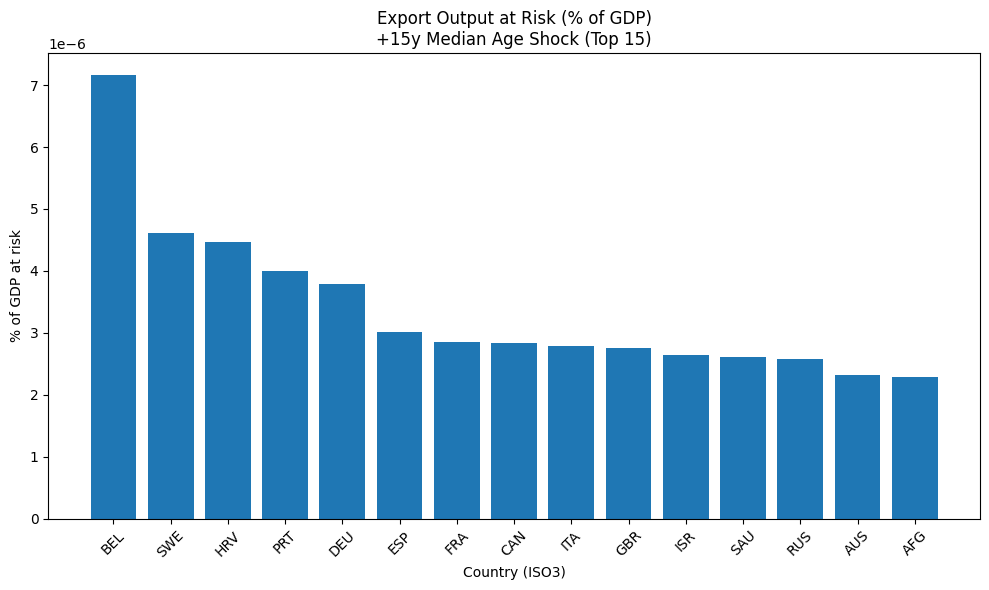

In [1]:
#Q6

import pandas as pd
import matplotlib.pyplot as plt

FILE = "final_with_indexes.csv"
ALPHA = 0.006
DEFAULT_MEDIAN_AGE = 35
AGE_SHOCKS = [5, 10, 15]

df = pd.read_csv(FILE)

iso_col = "ISO3"
year_col = "Year"
exports_col = "Exports of goods and services (% of GDP)"
unemp_col = "Unemployment,_total_(%_of_total_labor_force)_(modeled_ILO_estimate)"

latest = (
    df.sort_values(year_col)
      .groupby(iso_col, as_index=False)
      .tail(1)
      .reset_index(drop=True)
)

base = latest[[iso_col, year_col, exports_col, unemp_col]].copy()

if "Median_Age" in latest.columns:
    base["Median_Age"] = latest["Median_Age"]
else:
    base["Median_Age"] = DEFAULT_MEDIAN_AGE

for c in [exports_col, unemp_col, "Median_Age"]:
    base[c] = pd.to_numeric(base[c], errors="coerce")

base = base.dropna(subset=[exports_col, unemp_col, "Median_Age"]).reset_index(drop=True)

base["Labor_Tightness"] = 1 - base[unemp_col].clip(lower=0, upper=30) / 100.0

def effective_labor_drop(delta_years):
    raw = ALPHA * delta_years
    return raw * base["Labor_Tightness"]

for shock in AGE_SHOCKS:
    base[f"Labor_Shortage_{shock}y(%)"] = effective_labor_drop(shock) * 100
    base[f"Export_Risk_{shock}y(%GDP)"] = (
        base[exports_col] / 100.0 * effective_labor_drop(shock) * 100.0
    )

ranked = base.sort_values("Export_Risk_15y(%GDP)", ascending=False).reset_index(drop=True)

ranked.to_csv("export_aging_risk_simulation.csv", index=False)

for shock in AGE_SHOCKS:
    print(f"\n--- Top 10 countries most at risk (+{shock}y median age) ---")
    print(
        base[[iso_col, f"Export_Risk_{shock}y(%GDP)"]]
        .sort_values(f"Export_Risk_{shock}y(%GDP)", ascending=False)
        .head(10)
        .to_string(index=False)
    )

top15 = ranked.head(15)
plt.figure(figsize=(10,6))
plt.bar(top15[iso_col], top15["Export_Risk_15y(%GDP)"])
plt.title("Export Output at Risk (% of GDP)\n+15y Median Age Shock (Top 15)")
plt.xlabel("Country (ISO3)")
plt.ylabel("% of GDP at risk")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("top15_export_risk_15y.png")
plt.show()


In [2]:
#Q8

import pandas as pd
import numpy as np

FILE = "final_with_indexes.csv"
ISO = "ISO3"
YEAR = "Year"
GDP = "GDP (current US$)"
EXP_PCT = "Exports of goods and services (% of GDP)"
IMP_PCT = "Imports of goods and services (% of GDP)"
N = 25
ELASTICITY = 0.5  # % GDP change per 1% trade loss

df = pd.read_csv(FILE)
df = df[[ISO, YEAR, GDP, EXP_PCT, IMP_PCT]].copy()
for c in [GDP, EXP_PCT, IMP_PCT]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[ISO, YEAR, GDP, EXP_PCT, IMP_PCT])
latest = df.sort_values(YEAR).groupby(ISO, as_index=False).tail(1)

latest["Exports_Value"] = latest[GDP] * latest[EXP_PCT] / 100.0
latest["Imports_Value"] = latest[GDP] * latest[IMP_PCT] / 100.0
top = latest.sort_values("Exports_Value", ascending=False).head(N).reset_index(drop=True)

imports = top.set_index(ISO)["Imports_Value"].to_dict()
exports = top.set_index(ISO)["Exports_Value"].to_dict()
gdps = top.set_index(ISO)[GDP].to_dict()
countries = list(top[ISO])

flows = []
for i in countries:
    denom = sum(imports[j] for j in countries if j != i)
    if denom <= 0:
        continue
    for j in countries:
        if j == i:
            continue
        w = exports[i] * (imports[j] / denom)
        flows.append((i, j, w))
flows_df = pd.DataFrame(flows, columns=["i","j","flow_ij"])

pairs = flows_df.merge(flows_df.rename(columns={"i":"j","j":"i","flow_ij":"flow_ji"}), on=["i","j"], how="inner")
pairs = pairs[pairs["i"] < pairs["j"]].copy()

pairs["dep_i_on_j"] = pairs["flow_ij"] / pairs["i"].map(gdps)
pairs["dep_j_on_i"] = pairs["flow_ji"] / pairs["j"].map(gdps)
pairs["mutual_benefit_score"] = np.sqrt(pairs["dep_i_on_j"] * pairs["dep_j_on_i"])

pairs["gdp_impact_i_pct"] = pairs["dep_i_on_j"] * 100 * ELASTICITY
pairs["gdp_impact_j_pct"] = pairs["dep_j_on_i"] * 100 * ELASTICITY
pairs["gdp_impact_i_usd"] = pairs["gdp_impact_i_pct"] / 100 * pairs["i"].map(gdps)
pairs["gdp_impact_j_usd"] = pairs["gdp_impact_j_pct"] / 100 * pairs["j"].map(gdps)

out_cols = ["i","j","flow_ij","flow_ji","mutual_benefit_score",
            "gdp_impact_i_pct","gdp_impact_j_pct","gdp_impact_i_usd","gdp_impact_j_usd"]
result = pairs.sort_values("mutual_benefit_score", ascending=False)[out_cols].reset_index(drop=True)

print(result.head(15).to_string(index=False))
result.to_csv("top_mutual_benefit_pairs.csv", index=False)


  i   j  flow_ij  flow_ji  mutual_benefit_score  gdp_impact_i_pct  gdp_impact_j_pct  gdp_impact_i_usd  gdp_impact_j_usd
CHN DEU 0.435206 0.390599          4.534156e-08      1.191017e-06      4.315339e-06          0.217603          0.195299
DEU USA 0.484066 0.401510          3.936002e-08      5.347968e-06      7.242056e-07          0.242033          0.200755
BEL DEU 0.057395 0.068721          3.676827e-08      4.451579e-06      7.592282e-07          0.028697          0.034360
CHN USA 0.939697 0.699544          3.602681e-08      2.571644e-06      1.261771e-06          0.469849          0.349772
DEU FRA 0.139216 0.114452          3.396500e-08      1.538054e-06      1.875132e-06          0.069608          0.057226
BEL CHN 0.099998 0.133405          3.365454e-08      7.755912e-06      3.650853e-07          0.049999          0.066702
DEU GBR 0.140051 0.117945          3.291053e-08      1.547289e-06      1.750001e-06          0.070026          0.058973
CHN FRA 0.270253 0.199407          3.108